# Satellite Earth's outgoing longwave and shortwave radiation budget intercomparison for climate monitoring

Production date: 11-06-2025

Produced by: CNR-ISMAR, Andrea Storto, Vincenzo de Toma

## 🌍 Use case: Consistency assessment of Earth Radiation Budget products.

## ❓ Quality assessment question(s)
* **How consistent are the Earth Radiation Budget products provided by C3S?**

The Earth Radiation Budget (ERB) Outgoing Longwave Radiation (OLR) and Outgoing Shortwave Radiation (OSR) products allow quantifying outgoing longwave and shortwave radiation, respectively, which are in turn important for several climate applications. In particular, a non-exhaustive list of possible applications include: i) evaluation and potential improvement of climate models, through routinely validation of CMIP individual simulations and ensembles against OLR and OSR data, allowing to assess the net radiative forcing and possibly leading to improved configurations through re-tuning of e.g. aerosol-cloud interactions, radiative transfer schemes, etc.; ii) tracking the Earth's Energy Imbalance (EEI), which consist of long-term mean imbalance of incoming and outgoing energy at the top-of-the-atmosphere (TOA). This imbalance is mostly accumulated into the oceans, and its analysis is crucial to monitor recent global warming; iii) diagnosing El-Nino Southern Oscillation (ENSO) and other climate variability modes, which are intimately linked to anomalies of OLR (e.g. enhanced convection); iv) analyse cloud radiative effects (e.g. in combination with clear-sky radiative data) and their impact on climatic changes; and many more.
However, their temporal coverage and spatial detail varies across the ERB products. Over the overlapping periods, the products are in good agreement, except for the OLR at high latitudes (e.g. north of 60*N / south of 60°S), while discrepancies in OSR arise at both mid- (generally less than 10 Wm-2) and hig-latitudes.

## 📢 Quality assessment statement

```{admonition} These are the key outcomes of this assessment
:class: note
* The OLR/OSR products capture the spatial and temporal variability of the outgoing longwave radiation / outgoing shortwave radiation (at the top of the atmosphere) for use in climate analyses, climate model evaluations, and radiative forcing studies.
* The ERB OLR/OSR products have different temporal coverage and spatial resolution, namely their combined use is not straightforward and it is recommended for advanced users only, or for selected periods.
* The consistency between the products concerning spatially averaged values is generally acceptable. Climatological maps and zonally averaged values indicate that the products are sufficiently consistent in most areas, although differences exist and tend to increase near the polar regions.
```

The estimation of outgoing longwave radiation (OLR) at the top of the atmosphere is crucial for understanding the Earth's radiation budget (ERB), which plays a significant role in climate dynamics and energy balance. Despite its importance, accurately assessing OLR-ERB variability using remote sensing data and satellite missions is fraught with challenges due to calibration inconsistencies, data gaps, and the complex interactions of radiation with atmospheric constituents ([[1]](https://doi.org/10.1175/2008JCLI2637.1); 
[[2]](https://doi.org/10.1038/35066553)); [[3]](https://doi.org/10.1175/1520-0477%281996%29077%3C0853:CATERE%3E2.0.CO;2); [[4]](https://doi.org/10.1007/s10712-012-9175-1)).

```{figure} attachment:5b014617-673d-41e8-a581-2e22be10c7ec.png
Monthly mean time series of OLR (first row), OSR (second row) "Ensemble mean EEI" (third row) for different geographical regions (columns). 
```
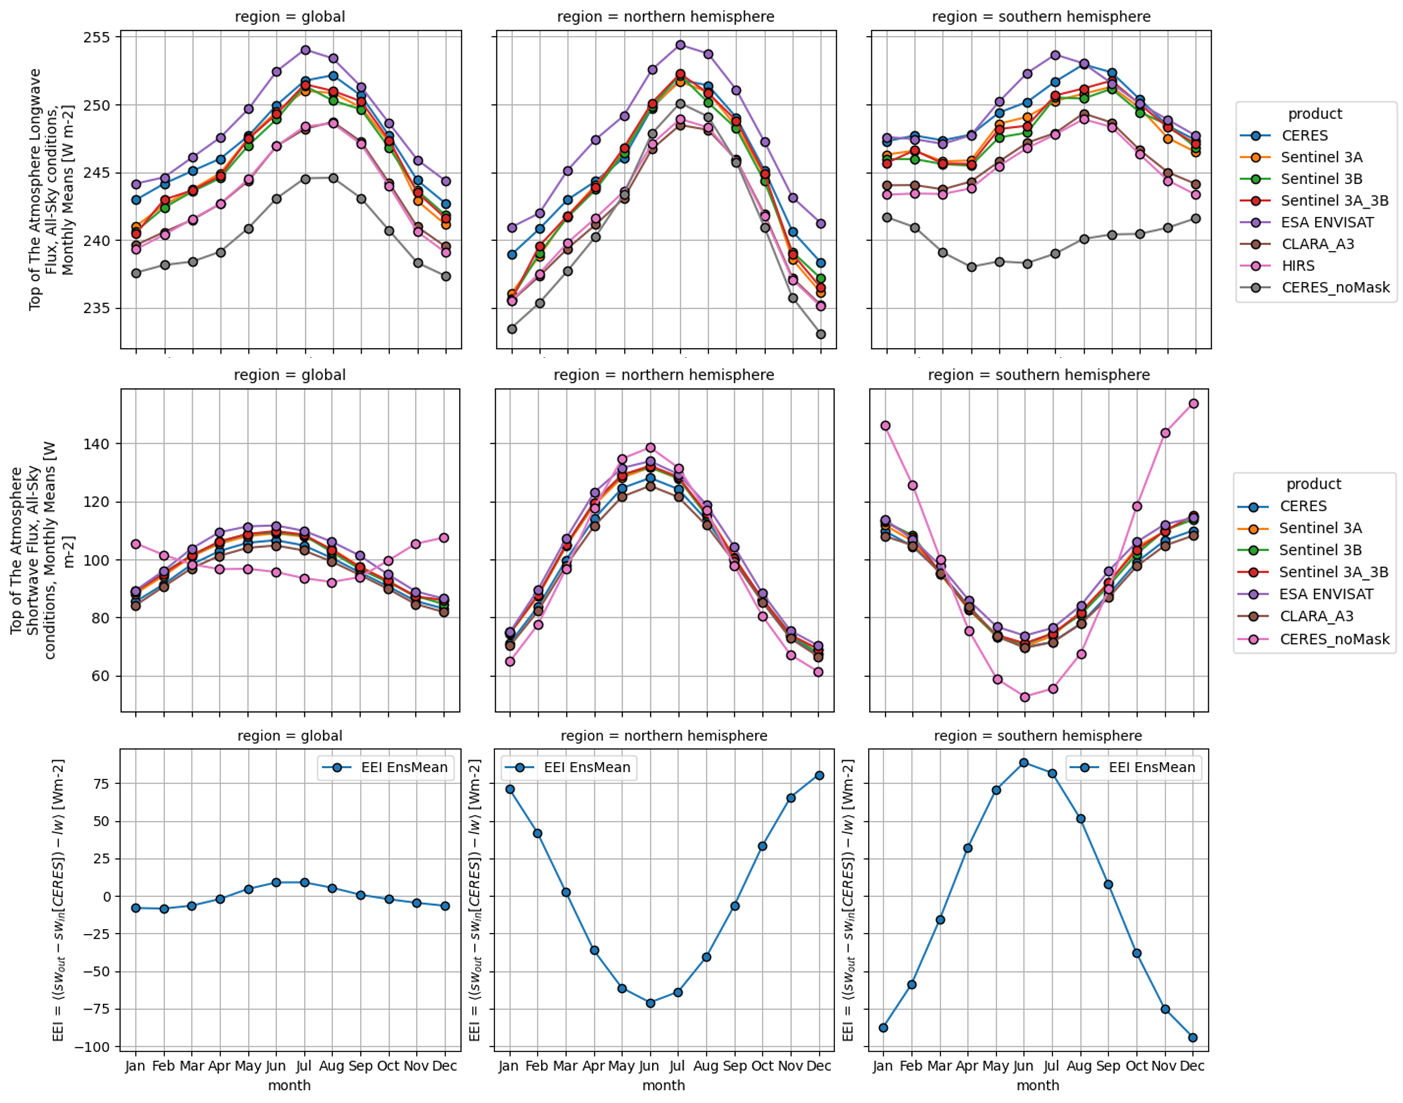

## 📋 Methodology

In this notebook we inter-compare the following catalogue entries from the Climate Data Store (CDS) by C3S:
1. CERES Energy Balanced and Filled (EBAF) TOA Monthly means data in netCDF Edition4.1. NASA Langley Atmospheric Science Data Center DAAC (NASA CERES EBAF)
2. NOAA CDR Program, (2018): NOAA Climate Data Record (CDR) of Monthly Outgoing Longwave Radiation (OLR), Version 2.7 (NOAA/NCEI HIRS).
3. Earth's radiation budget from 1979 to present derived from satellite observations. CCI ICDR product version 3.1. Copernicus Climate Change Service Climate Data Store (C3S CCI).
4. ESA Cloud Climate Change Initiative (ESA Cloud_cci) data: Cloud_cci ATSR2-AATSR L3C/L3U CLD_PRODUCTS v3.0 (ESA Cloud CCI).

CERES is the only product which gives also the incoming shortwave radiation: thus, in order to evaluate the EEI, the ensemble mean budget was built using outgoing longwave and outgoing shortwave from each product, and the incoming shortwave from CERES, and then averaging across the product dimension. 

The analysis and results are organised in the following steps, which are detailed in the sections below:

**[](choose-the-data-to-use-and-setup-code)**

**[](download-and-transform)**

**[](plot-spatial-weighted-time-series)**

**[](plot-time-weighted-means)**

**[](plot-spatial-weighted-zonal-means)**

## 📈 Analysis and results

(choose-the-data-to-use-and-setup-code)=
### 1. Choose the data to use and setup code

In this section, we import the required packages and set up the dataset names for further use in the following sections. Processing functions are also defined. We select only complete years available for each dataset in order to have a fair comparison between different products.

In [1]:
import os
os.environ["CDSAPI_RC"] = os.path.expanduser("~/detoma_vincenzo/.cdsapirc")
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime
from cartopy import crs as ccrs, feature as cfeature
import cartopy.mpl.ticker as cticker
from c3s_eqc_automatic_quality_control import download, plot, utils, diagnostics
import warnings
warnings.filterwarnings("ignore")

# Variable to analyse
variables = ["outgoing_longwave", "outgoing_shortwave", "incoming_shortwave"]
request_dicts = []

for variable in variables:

    # Region for timeseries
    region_slices = {
        "global": {"lat_slice": slice(-90, 90), "lon_slice": slice(0, 360)},
        "northern hemisphere": {"lat_slice": slice(0, 90), "lon_slice": slice(0, 360)},
        "southern hemisphere": {"lat_slice": slice(-90, 0), "lon_slice": slice(0, 360)},
    }

    collection_id = "satellite-earth-radiation-budget"
    chunks = {"year": 1}
    varnames = (
        {"olr", "toa_lw_all_mon"} if variable == "outgoing_longwave" else {"rsf", "toa_sw_all_mon"}
    )

    collection_id = "satellite-earth-radiation-budget"
    chunks = {"year": 1}
    varnames = (
        {"olr", "toa_lw_all_mon", "LW_flux"}
        if variable == "outgoint_longwave"
        else {"rsf", "toa_sw_all_mon", "SW_flux"}
    )

    request_dict = {
        "CERES": {
            "start": "2001-01",
            "stop": "2023-12",
            "product_family": "ceres_ebaf",
            "climate_data_record_type": "thematic_climate_data_record",
            "time_aggregation": "monthly_mean",
            "format": "zip",
            "origin": "nasa",
            "variable": f"{variable}_radiation",
        },
        "Sentinel 3A": {
            "start": "2017-01",
            "stop": "2021-12",
            "format": "zip",
            "origin": "c3s",
            "sensor_on_satellite": "slstr_on_sentinel_3a",
            "variable": "all_variables",
            "product_family": "cci",
            "time_aggregation": "monthly_mean",
            "climate_data_record_type": "interim_climate_data_record",
        },
        "Sentinel 3B": {
            "start": "2019-01",
            "stop": "2021-12",
            "format": "zip",
            "origin": "c3s",
            "sensor_on_satellite": "slstr_on_sentinel_3b",
            "variable": "all_variables",
            "product_family": "cci",
            "time_aggregation": "monthly_mean",
            "climate_data_record_type": "interim_climate_data_record",
        },
        "Sentinel 3A_3B": {
            "start": "2019-01",
            "stop": "2021-12",
            "format": "zip",
            "origin": "c3s",
            "sensor_on_satellite": "slstr_on_sentinel_3a_3b",
            "variable": "all_variables",
            "product_family": "cci",
            "time_aggregation": "monthly_mean",
            "climate_data_record_type": "interim_climate_data_record",
        },
        "ESA ENVISAT": {
            "start": "2003-01",
            "stop": "2011-12",
            "format": "zip",
            "origin": "esa",
            "product_family": "cci",
            "climate_data_record_type": "thematic_climate_data_record",
            "time_aggregation": "monthly_mean",
            "sensor_on_satellite": "aatsr",
            "variable": "all_variables",
        },
        "CLARA_A3": {
            "start": "1979-01",
            "stop": "2020-12",
            "product_family": "clara_a3",
            "origin": "eumetsat",
            "variable": f"{variable}_radiation",
            "climate_data_record_type": "thematic_climate_data_record",
            "time_aggregation": "monthly_mean",
        },
        "HIRS": {
            "start": "1979-01",
            "stop": "2023-12",
            "format": "zip",
            "origin": "noaa_ncei",
            "product_family": "hirs",
            "climate_data_record_type": "thematic_climate_data_record",
            "time_aggregation": "monthly_mean",
            "version": "2_7_reprocessed",
            "variable": f"{variable}_radiation",
        },
        "CERES_noMask": {
            "start": "2001-01",
            "stop": "2023-12",
            "product_family": "ceres_ebaf",
            "climate_data_record_type": "thematic_climate_data_record",
            "time_aggregation": "monthly_mean",
            "format": "zip",
            "origin": "nasa",
            "variable": f"{variable}_radiation",
        },
    }
    request_dicts.append(request_dict)

def preprocess_time(ds):
    if "time" in ds and "units" in ds["time"].attrs:
        # Could not decode
        ds = ds.squeeze("time", drop=True)
    if "time" not in ds:
        time = pd.to_datetime(ds.attrs["time_coverage_start"].replace("Z", ""))
        ds = ds.expand_dims(time=[time])
    return ds


def spatial_weighted_mean(ds, lon_slice, lat_slice, regrid, ds_obj, SKIP, mask=None):
    if mask is None:
        if regrid==True:
            ds = diagnostics.regrid(ds, ds_obj, method='bilinear', skipna=SKIP)
        ds = utils.regionalise(ds, lon_slice=lon_slice, lat_slice=lat_slice)
        return diagnostics.spatial_weighted_mean(ds, weights=True, skipna=SKIP)
    else:
        if regrid==True:
            ds = diagnostics.regrid(ds, ds_obj, method='bilinear', skipna=SKIP)
        ds = utils.regionalise(ds, lon_slice=lon_slice, lat_slice=lat_slice)
        mask = utils.regionalise(mask, lon_slice=lon_slice, lat_slice=lat_slice)
        return diagnostics.spatial_weighted_mean(ds.where(~np.isnan(mask)), weights=True, skipna=SKIP)

xarray_kwargs = {
    "drop_variables": ["time_bounds", "record_status"],
    "preprocess": preprocess_time,
}

(download-and-transform)=
### 2. Download and transform

The code below will download the products. Notice the definition of common periods for the different products, and their inclusion in the mean map dictionary. When the variable to download is the shortwave component, we skip the HIRS dataset, since only longwave is available within it.

In [2]:
weights=True
skipna=True
p = []
start_var = {}
stop_var = {}
DS = {}
for variable, request_dict in zip(variables, request_dicts):
    Ds = {}
    start_prod = {}
    stop_prod = {}
    for product, request in request_dict.items():
        if product == "HIRS" and variable != "outgoing_longwave":
            continue
        if "CERES" not in product and variable=="incoming_shortwave":
            continue
        p.append(product)
    
        start = request.pop("start")
        stop = request.pop("stop")
        start_prod[product] = start
        stop_prod[product] = stop
        
        requests = download.update_request_date(
            request, start=start, stop=stop, stringify_dates=True
        )
    
        ds = download.download_and_transform(
            collection_id,
            requests,
            #transform_func=diagnostics.time_weighted_mean,
            #transform_func_kwargs={'weights':True, 'skipna':False},
            chunks=chunks,
            transform_chunks=False,
            **xarray_kwargs,
            quiet=True,
        )
        Ds[product] = ds
    start_var[variable] = start_prod
    stop_var[variable] = stop_prod
    DS[variable] = Ds

In [3]:
clara_a3_start, clara_a3_end ="1980-01", "2020-12"
ceres_start, ceres_end = "2001-01", "2023-12"
esa_envisat_start, esa_envisat_end = "2003-01", "2011-12" 
sentinel_start, sentinel_end = "2019-01", "2021-12"

def mean_map_period(ds, start, stop, W, S):
    selection = ds.sel(time=slice(start, stop))
    time_coord =  np.array(pd.date_range(start, stop, freq='MS'), dtype=np.datetime64)
    ds = selection.assign_coords({'time':('time', time_coord, selection.time.attrs)})
    ds_map = diagnostics.time_weighted_mean(ds, weights=W, skipna=S)
    return ds_map

In [4]:
def get_varname(ds, variable):
    if variable=="outgoing_longwave":
        varnames = (
            {"olr", "toa_lw_all_mon", "LW_flux"}
        )
    elif variable=="outgoing_shortwave":
        varnames = (
            {"rsf", "toa_sw_all_mon", "SW_flux"}
        )
    else:
        varnames = (
            {"solar_mon"}
        )
        
    (varname,) = set(ds.data_vars) & varnames
    return varname

ds_maps = {}
ds_maps_p1 = {}
ds_maps_p2 = {}
ds_maps_p3 = {}
ds_maps_p4 = {}
p = []
for variable, request_dict in zip(variables, request_dicts):
    da_maps = {}
    da_maps_p1 = {}
    da_maps_p2 = {}
    da_maps_p3 = {}
    da_maps_p4 = {}
    for product, request in request_dict.items():
        if product == "HIRS" and variable != "outgoing_longwave":
            continue
        if "CERES" not in product and variable=="incoming_shortwave":
            continue
        p.append(product)
    
        start = start_var[variable][product]
        stop = stop_var[variable][product]

        ds = DS[variable][product]
        
        varname=get_varname(ds, variable)
        
        da = ds[varname]
        if product=="CERES":
            regrid=False
            da_obj = ds[varname]
        else:
            regrid=True
            da = diagnostics.regrid(da, da_obj, method='bilinear')
        da.attrs.update({"start": start, "stop": stop})
        da_maps[product] = diagnostics.time_weighted_mean(da, weights=True, skipna=False)

        curr_time = pd.date_range(start, stop)
        ceres_time = pd.date_range(ceres_start, ceres_end)
        clara_a3_time = pd.date_range(clara_a3_start, clara_a3_end)
        esa_envisat_time = pd.date_range(esa_envisat_start, esa_envisat_end)
        sentinel_time = pd.date_range(sentinel_start, sentinel_end)
        if clara_a3_time[0] in curr_time and clara_a3_time[-1] in curr_time:
            da_maps_p1[product] = mean_map_period(da, clara_a3_start, clara_a3_end, W=weights, S=skipna)
            da_maps_p1[product] = diagnostics.regrid(da_maps_p1[product].rename(variable), da_obj, method='bilinear')
        if ceres_time[0] in curr_time and ceres_time[-1] in curr_time:
            da_maps_p2[product] = mean_map_period(da, ceres_start, ceres_end, W=weights, S=skipna)
            da_maps_p2[product] = diagnostics.regrid(da_maps_p2[product].rename(variable), da_obj, method='bilinear')
        if esa_envisat_time[0] in curr_time and esa_envisat_time[-1] in curr_time:
            da_maps_p3[product] = mean_map_period(da, esa_envisat_start, esa_envisat_end, W=weights, S=skipna) 
            da_maps_p3[product] = diagnostics.regrid(da_maps_p3[product].rename(variable), da_obj, method='bilinear')
        if sentinel_time[0] in curr_time and sentinel_time[-1] in curr_time:
            da_maps_p4[product] = mean_map_period(da, sentinel_start, sentinel_end, W=weights, S=skipna) 
            da_maps_p4[product] = diagnostics.regrid(da_maps_p4[product].rename(variable), da_obj, method='bilinear')

    ds_maps_p1[variable] = da_maps_p1
    ds_maps_p2[variable] = da_maps_p2
    ds_maps_p3[variable] = da_maps_p3
    ds_maps_p4[variable] = da_maps_p4
    ds_maps[variable] = da_maps

In [5]:
listmasks = [ds_maps[k] for k in ds_maps.keys()]
lw_mask = xr.concat([xr.where(~np.isnan(listmasks[0][l]), 1, np.nan) for l in listmasks[0].keys()], dim='product').mean(['product'], skipna=False)
sw_mask = xr.concat([xr.where(~np.isnan(listmasks[1][l]), 1, np.nan) for l in listmasks[1].keys()], dim='product').mean(['product'], skipna=False)
mask = xr.concat([lw_mask, sw_mask], dim='variable').assign_coords({'variable':variables[:2]})

In [6]:
ds_timeseries = {}
p = []
for variable, request_dict in zip(variables, request_dicts):
    da_timeseries = {}
    for product, request in request_dict.items():
        if product == "HIRS" and variable != "outgoing_longwave":
            continue
        if "CERES" not in product and variable=="incoming_shortwave":
            continue
        p.append(product)
        
        start = start_var[variable][product]
        stop = stop_var[variable][product]

        ds = DS[variable][product]
        
        varname=get_varname(ds, variable)
        
        da = ds[varname]
        if product=="CERES":
            regrid=False
            da_obj = ds[varname]
        else:
            regrid=True
            da = diagnostics.regrid(da, da_obj, method='bilinear')
        da.attrs.update({"start": start, "stop": stop})
        
        regrid_dict={'regrid':regrid, 'ds_obj':da_obj}

        SkipNa={'SKIP': True}

        if product=="CERES_noMask":
            Mask = {'mask': None}
        elif variable=='incoming_shortwave':
            Mask = {'mask': None}  
        else:
            Mask = {'mask': mask.sel(variable=variable)}
        
        dataarrays = []
        for region, slices in region_slices.items():
            dall = {}
            dall.update(slices)
            dall.update(regrid_dict)
            dall.update(SkipNa)
            dall.update(Mask)
            da_ts = spatial_weighted_mean(da, lon_slice=dall['lon_slice'], lat_slice=dall['lat_slice'], regrid=dall['regrid'], ds_obj=dall['ds_obj'], SKIP=dall['SKIP'], mask=dall['mask'])
            dataarrays.append(da_ts.expand_dims(region=[region]))
        
        da = xr.concat(dataarrays, "region")
        da.attrs.update({"start": start, "stop": stop})
        da_timeseries[product] = da.rename(variable)
    ds_timeseries[variable] = da_timeseries

In [7]:
ds_periods_list = [ds_maps_p1, ds_maps_p2, ds_maps_p3, ds_maps_p4]
periods = [clara_a3_time, ceres_time, esa_envisat_time, sentinel_time]

(plot-spatial-weighted-time-series)=
### 3. Plot spatial weighted time series

Below, we calculate and plot spatially weighted means for the different earth radiation budget products, in terms of montly climatologies, although the sampling period of each dataset is, in general, different from the others. Despite each dataset has a different length, we want here to inspect how the different products reproduce the seasonal cycle, both for the global mean, and for each hemisphere. 

The pronounced seasonality in OLR is mostly linked with the larger land area in the Northern Hemisphere, while that one in OSR linked with the solar cycle.

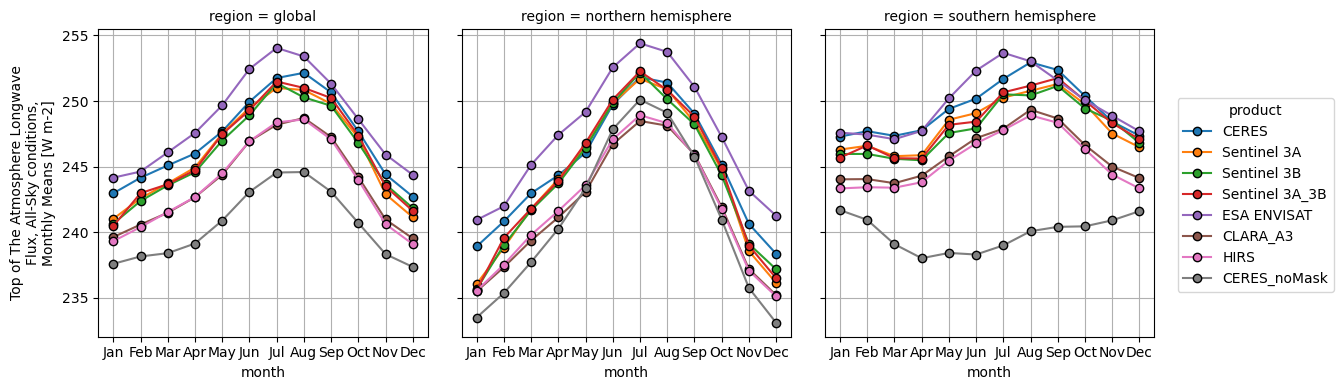

In [8]:
lw_ts = xr.concat([ds_timeseries['outgoing_longwave'][k] for k in ds_timeseries['outgoing_longwave'].keys()], dim='product', coords='minimal').assign_coords({'product': [k for k in ds_timeseries['outgoing_longwave'].keys()]})
sw_ts = xr.concat([ds_timeseries['outgoing_shortwave'][k] for k in ds_timeseries['outgoing_shortwave'].keys()], dim='product', coords='minimal').assign_coords({'product': [k for k in ds_timeseries['outgoing_shortwave'].keys()]})

t1 = lw_ts.groupby('time.month').mean('time').plot(col='region', hue='product', figsize=(12,4), marker='o', markeredgecolor='k') #.resample(time='1M').mean()
for ax in t1.axs.flatten():
    ax.set_xticks([1,2,3,4,5,6,7,8,9,10,11,12])
    ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    ax.grid()
    

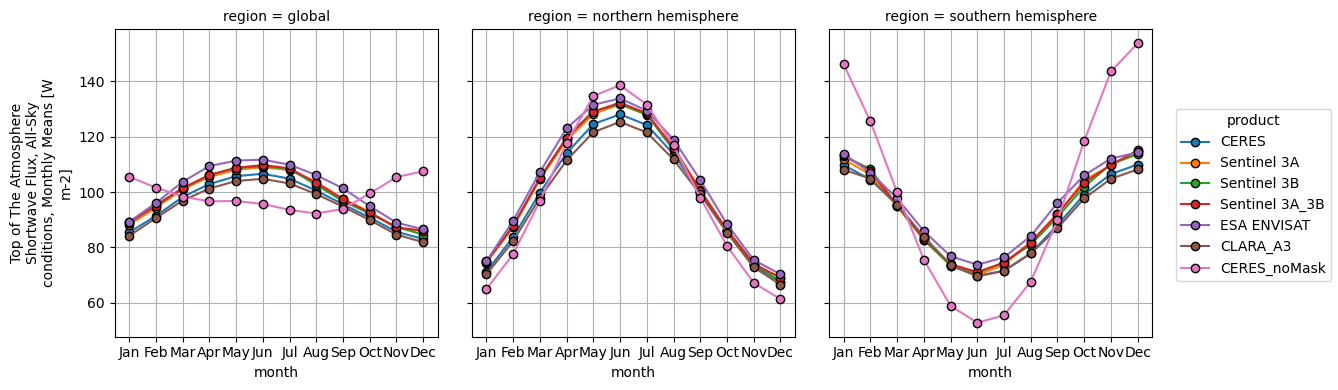

In [9]:
t2 = sw_ts.groupby('time.month').mean('time').plot(col='region', hue='product', figsize=(12,4), marker='o', markeredgecolor='k') #.resample(time='1M').mean()
for ax in t2.axs.flatten():
    ax.set_xticks([1,2,3,4,5,6,7,8,9,10,11,12])
    ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    ax.grid()

The offsets are greater in OLR than in OSR, with the ESA product (ENVISAT) are positively biased compared to the other products.

In [10]:
p_nohirs = sw_ts.product.values
res_var = {}

def fix_lon(ds):
    if ds.longitude.max().values>350.:
        ds['longitude'] = ((ds['longitude'] + 180) % 360) - 180
        # Step 2: Sort by the new longitude values to maintain increasing order
        ds = ds.sortby('longitude')
    else:
        ds=ds
    return ds
    
for request_dict in request_dicts:
    prod = {}
    for product, request in request_dict.items():
        if product == "HIRS" and variable != "outgoing_longwave":
            continue
        p.append(product)

        lw_ds = DS['outgoing_longwave'][product].groupby('time.month').mean('time')
        sw_ds = DS['outgoing_shortwave'][product].groupby('time.month').mean('time')
        sw_ds_in = DS['incoming_shortwave']['CERES'].groupby('time.month').mean('time')
        sw_ds_in = fix_lon(sw_ds_in)
        lw_ds = fix_lon(lw_ds)
        sw_ds = fix_lon(sw_ds)

        shortname_out = get_varname(sw_ds, 'outgoing_shortwave')
        longname = get_varname(lw_ds, 'outgoing_longwave')
        shortname_in = get_varname(sw_ds_in, 'incoming_shortwave')
        da = np.abs(sw_ds[shortname_out]) - np.abs(sw_ds_in[shortname_in]) + np.abs(lw_ds[longname])
        dataarrays = []
        for region, slices in region_slices.items():
            dall = {}
            dall.update(slices)
            dall.update(regrid_dict)
            dall.update(SkipNa)
            dall.update(Mask)
            da_sel = da.sel(longitude=dall['lon_slice'], latitude=dall['lat_slice'])
            da_ts = da_sel.weighted(np.cos(da_sel.latitude*np.pi/180.)).mean(['longitude', 'latitude'])
            #da_ts = spatial_weighted_mean(da, lon_slice=dall['lon_slice'], lat_slice=dall['lat_slice'], regrid=dall['regrid'], ds_obj=dall['ds_obj'], SKIP=dall['SKIP'], mask=dall['mask'])
            dataarrays.append(da_ts.expand_dims(region=[region]))
        
        da = xr.concat(dataarrays, "region")
        prod[product] = da
    res_var['EEI'] = prod

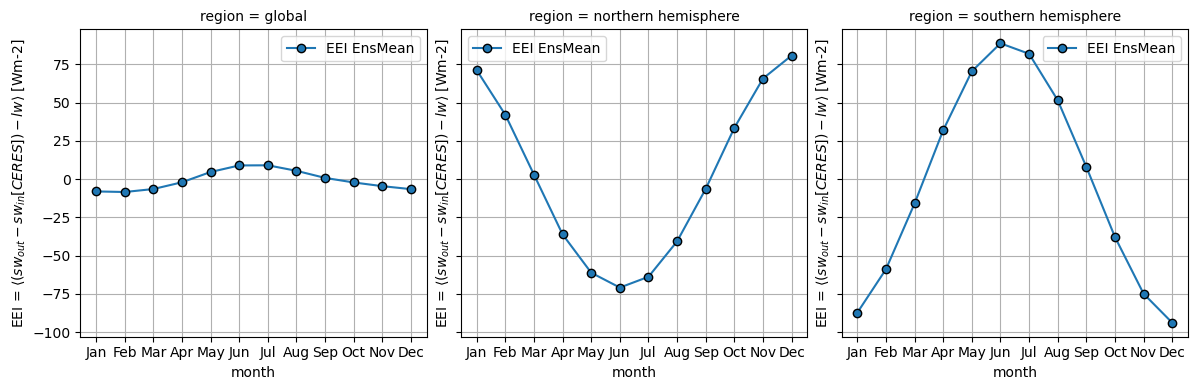

In [11]:
res = xr.concat([res_var['EEI'][p] for p in p_nohirs], dim='product').assign_coords({'product': p_nohirs}).mean('product')
t3 = res.plot(col='region', figsize=(12,4), marker='o', markeredgecolor='k', label='EEI EnsMean') #.resample(time='1M').mean()
for ax in t3.axs.flatten():
    ax.set_ylabel(r'EEI = $\langle (sw_{out} - sw_{in}[CERES]) - lw\rangle$ [Wm-2]')
    ax.set_xticks([1,2,3,4,5,6,7,8,9,10,11,12])
    ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    ax.legend(loc='best')
    ax.grid()

Next, we show the EEI at the TOA. The EEI is the small difference between the sunlight the Earth absorbs and the thermal (longwave) plus reflected (shortwave) radiation it emits, and represents a fundamental "engine" of climate change. Even a tiny positive imbalance (on the order of 0.5-1 Wm-2) sustained year after year is what drives ocean heat uptake, ice melt, sea-level rise and ultimately the global temperature increase we observe.

The global average of EEI indicates a small seasonal cycle (about 15 Wm-2 peak-to-peak) compared to hemispheric averages, with a slight maximum EEI in June-July. That means mid-year the Earth is absorbing just a bit more energy than at other times, largely because Northen Hemisphere land is warm, and snow-free.

(plot-time-weighted-means)=
### 4. Plot time weighted means
Below, we calculate and plot time-weighted means for the different radiation budget products. Please note that different periods were considered, in order to make fair comparison between products wich have a different temporal extent.

In [12]:
listmasks = [ds_maps[k] for k in ds_maps.keys()]
lw_mask = xr.concat([xr.where(~np.isnan(listmasks[0][l]), 1, np.nan) for l in listmasks[0].keys()], dim='product').mean(['product'], skipna=False)
sw_mask = xr.concat([xr.where(~np.isnan(listmasks[1][l]), 1, np.nan) for l in listmasks[1].keys()], dim='product').mean(['product'], skipna=False)

mask = xr.concat([lw_mask, sw_mask], dim='variable').assign_coords({'variable':variables[:2]})

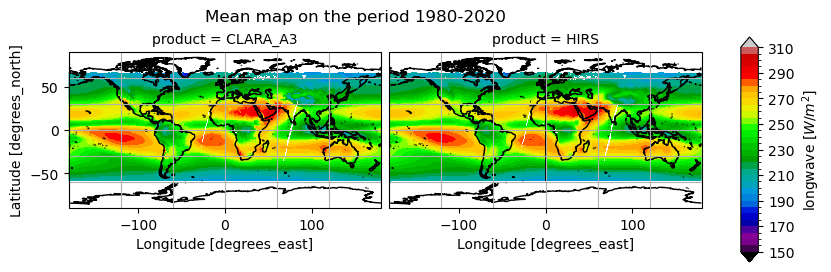

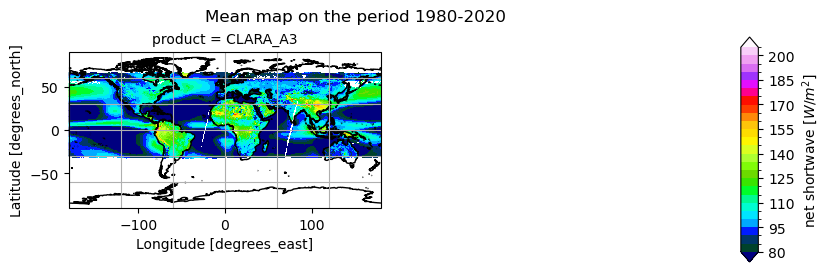

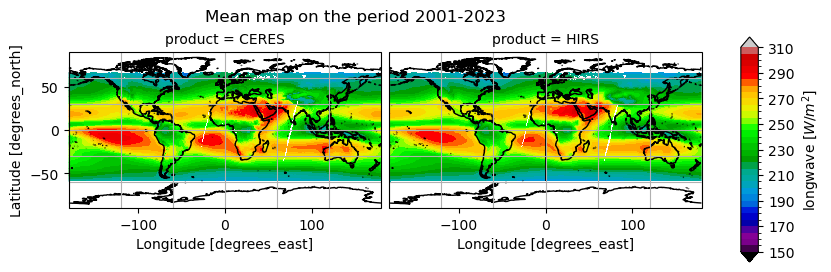

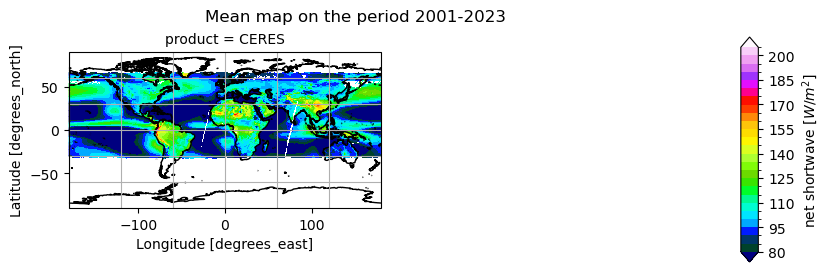

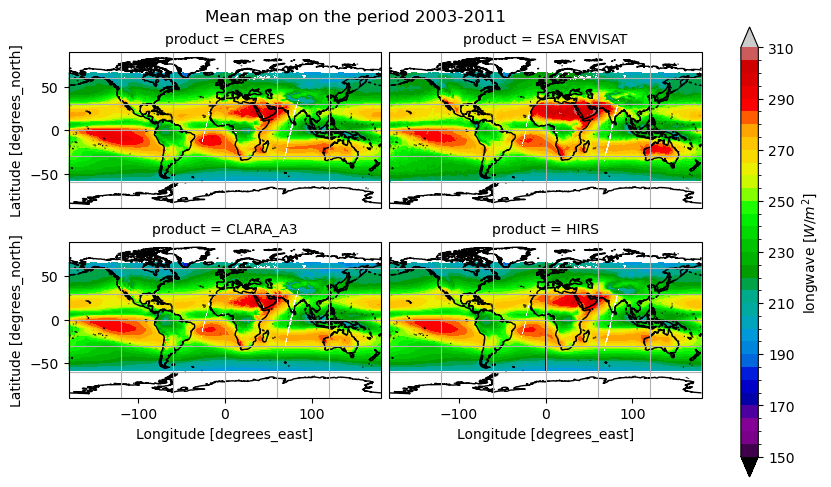

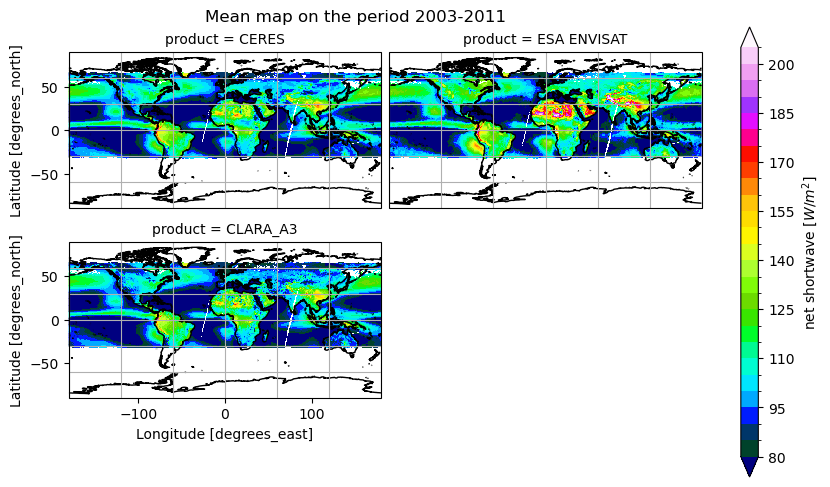

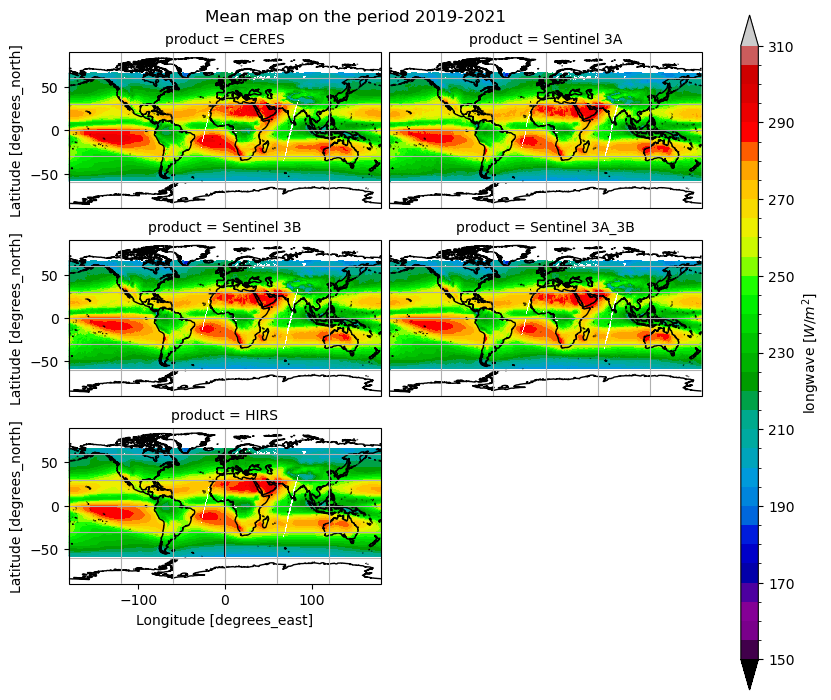

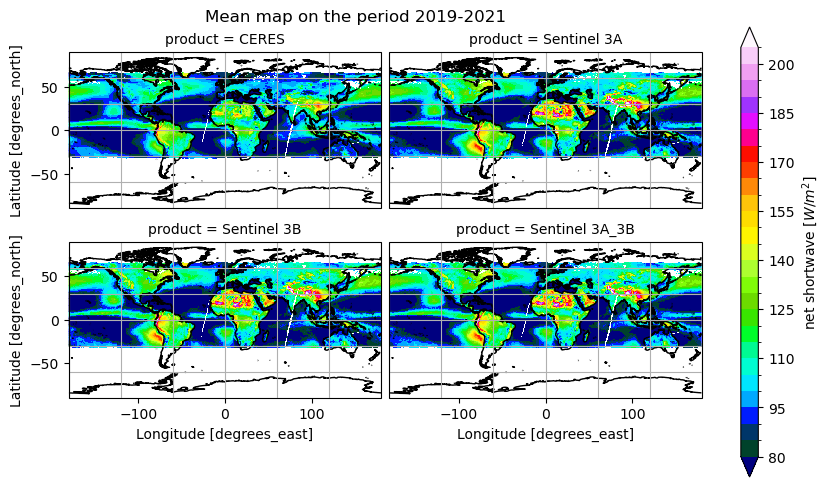

In [13]:
for ds_maps, times in zip(ds_periods_list, periods):
    p_to_show = []
    for k in ds_maps['outgoing_longwave'].keys():
        if k=='CERES_noMask':
            continue
        else:
            p_to_show.append(k)
    
    p_to_show_whirs = p_to_show.copy()
    p_to_show.remove("HIRS")
    lw_maps = xr.concat([ds_maps['outgoing_longwave'][p] for p in p_to_show_whirs], dim='product').assign_coords({'product': p_to_show_whirs})
    lw_maps_masked = lw_maps.where(~np.isnan(mask.sel(variable='outgoing_longwave')))
    p1 = lw_maps_masked.plot(col='product', 
                             col_wrap=2,
                             subplot_kws={'projection': ccrs.PlateCarree()},
                             levels=range(150, 315, 5),
                             extend="both",
                             cmap="nipy_spectral",
                             add_colorbar=False,
                             transform=ccrs.PlateCarree())
    for ax in p1.axs.flat:  # loop through the map axes
        subplotspec = ax.get_subplotspec()
        if subplotspec.is_last_row():
            ax.xaxis.set_visible(True)
        if subplotspec.is_first_col():
            ax.yaxis.set_visible(True)
        ax.coastlines('50m')
        ax.gridlines()
    p1.fig.set_layout_engine("compressed")
    cax = p1.fig.add_axes([1.05, 0.1, 0.025, 0.75])
    p1.add_colorbar(cax=cax, orientation='vertical', label=r'longwave [$W/m^{2}$]')
    p1.fig.suptitle(f'Mean map on the period {times[0].year}-{times[-1].year}')
    if len(p_to_show)>0:
        sw_maps = xr.concat([ds_maps['outgoing_shortwave'][p] for p in p_to_show], dim='product').assign_coords({'product': p_to_show})
        sw_maps_masked = sw_maps.where(~np.isnan(mask.sel(variable='outgoing_shortwave')))
        p2 = sw_maps_masked.plot(col='product',
                                 col_wrap=2, 
                                 subplot_kws={'projection': ccrs.PlateCarree()},
                                 levels= range(80, 210, 5),
                                 extend="both",
                                 cmap="gist_ncar",
                                 add_colorbar=False,
                                 transform=ccrs.PlateCarree())
        for ax in p2.axs.flat:  # loop through the map axes
            subplotspec = ax.get_subplotspec()
            if subplotspec.is_last_row():
                ax.xaxis.set_visible(True)
            if subplotspec.is_first_col():
                ax.yaxis.set_visible(True)
            ax.coastlines('50m')
            ax.gridlines()
        p2.fig.set_layout_engine("compressed")
        cax = p2.fig.add_axes([1.05, 0.1, 0.025, 0.75])
        p2.add_colorbar(cax=cax, orientation='vertical', label=r'net shortwave [$W/m^{2}$]')
        p2.fig.suptitle(f'Mean map on the period {times[0].year}-{times[-1].year}')

Time mean spatial maps show consistent spatial features across the products, although with large offsets and difference (e.g. near the Equator, at high latitudes). Differences are also due to varying spatial resolution, and different temporal and spatial sampling across the products.

All products show highest OLR over the subtropical deserts (e.g. Sahara, Arabian Peninsula, central Australia) and clear‐skies over the eastern subtropical ocean gyres, and lowest OLR where deep convection occurs (ITCZ, tropical rainforests) and at high latitudes under clouds. All OLR products agree on the major “warm” desert maxima and “cold” convective minima. Differences are very small (<5 Wm-2) in the well‐sampled tropical belt; AIRS can show a bit more structure in the Intertropical Convergence Zone (likely due to higher spectral resolution), whereas the other products tend to smooth the strongest minima and maxima slightly. 
Concerning the OSR, all products feature bright subtropical desert maxima (200–220 W m⁻²), low OSR (80–100 W m⁻²) in persistently cloudy regions (ITCZ, midlatitude storm tracks, equatorial Pacific), and moderate values (120–160 W m⁻²) over clear‐sky oceans. The spatial patterns are remarkably consistent across the products, with differences generally of the order of less than 4 Wm-2.


(plot-spatial-weighted-zonal-means)=
### 5. Plot spatial weighted zonal means
The code below will calculate and plot weighted zonal means for the radiation budget products. For the sake of comparison, different periods are shown consistently with different temporal overlapping windows. 

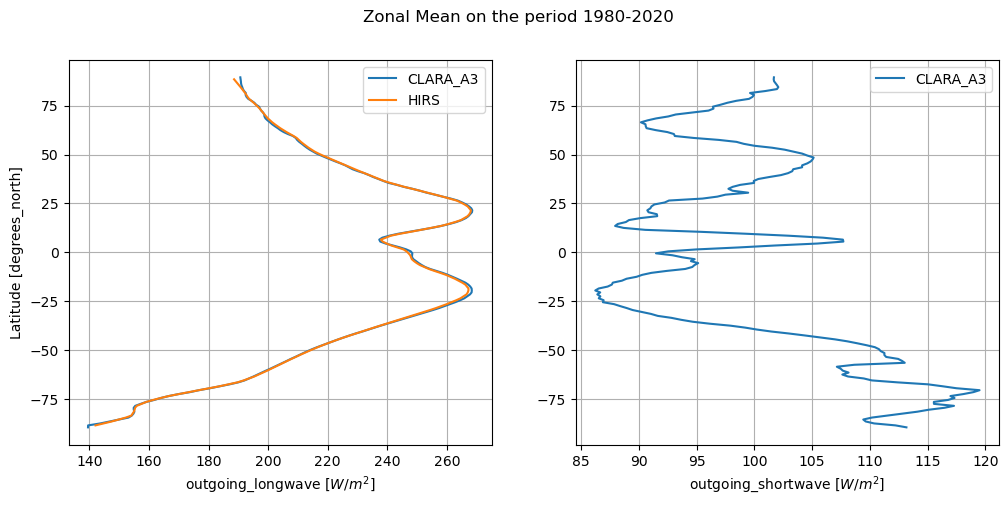

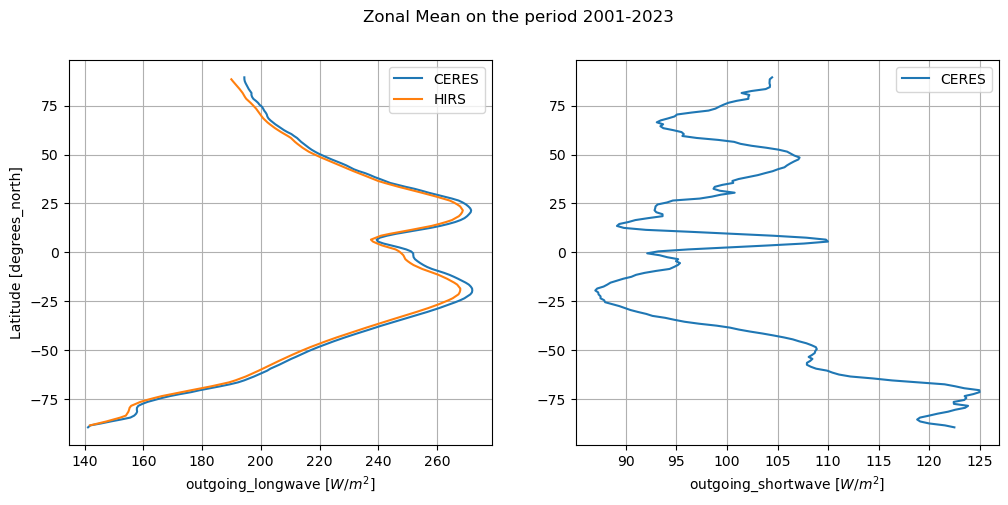

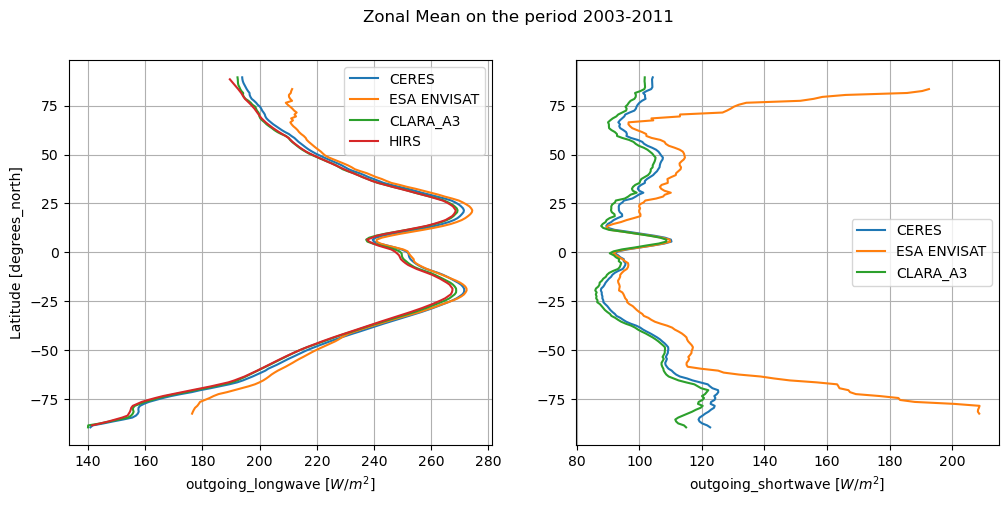

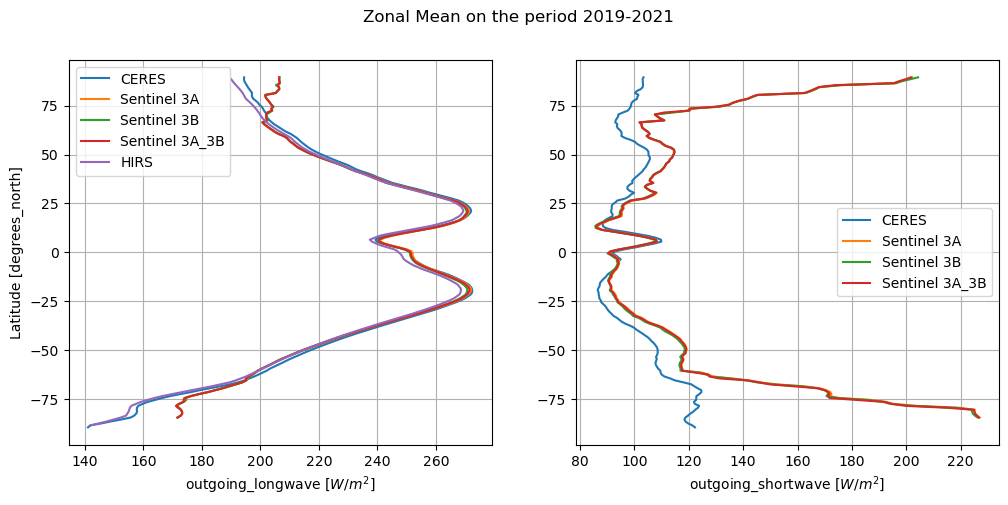

In [14]:
i=0
for ds_maps, times in zip(ds_periods_list, periods):
    fig=plt.figure(i, figsize=(12,5))
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    fig.suptitle(f'Zonal Mean on the period {times[0].year}-{times[-1].year}')
    for variable, da_maps in ds_maps.items():
        if variable=='incoming_shortwave':
            continue
        ax=ax1 if variable=='outgoing_longwave' else ax2
        for product, da in da_maps.items():
            if product=='CERES_noMask':
                continue
            else:
                da = diagnostics.spatial_weighted_mean(da, dim="longitude")
                da = da.where(da!=0, np.nan)
                da.plot(ax=ax, y="latitude", label=product)
        ax.legend(loc='best')
        if variable=='outgoing_shortwave':
            ax.set_ylabel('')
        ax.grid()
        ax.set_xlabel(f"{variable} [$W/m^2$]")
    i=i+1

Zonal averages indicate the good consistency among the products, except at thig latitudes (e.g., south of 50°S and north of 50°N). In particular, CERES and ESA ENVISAT show good agreement in the OLR, with CLARA_A3 and HIRS possibly deviating slightly, especially at higher latitudes. Also, OSR shows the largest discrepancies going poleward, which may arise from differences in cloud detection or albedo algorithms.

#### Discussion and applications

Satellite-derived outgoing longwave radiation (OLR) is a valuable metric in climate investigations, providing insights into the Earth's energy balance and temperature distribution. OLR measurements, derived from satellites such as the National Oceanic and Atmospheric Administration's (NOAA) Advanced Very High Resolution Radiometer (AVHRR) and the Atmospheric Infrared Sounder (AIRS) onboard NASA's Aqua satellite, enable researchers to monitor cloud cover, humidity, and the thermal properties of the Earth's surface ([[5]](https://doi.org/10.1029/2012JD017997); [[6]](https://doi.org/10.1073/pnas.1412190111)). By analyzing OLR data over extended periods, scientists can identify trends related to climate change and variability, such as the effects of El Niño and La Niña phenomena on global temperatures ([[7](https://doi.org/10.1002/2017JD027002)). For example, regional studies have leveraged OLR anomalies to quantify cloud radiative effects in the Arctic, revealing how changing sea-ice cover alters the outgoing longwave flux and contributes to polar amplification. Furthermore, OLR can be used to validate regional climate models and improve predictions of future climate scenarios, thus playing a crucial role in understanding both present conditions and future climate dynamics ([[8]](https://doi.org/10.1175/JCLI3799.1)). Benchmarking model outputs against multi-decadal OLR records has led to more accurate estimates of water-vapor and cloud feedback strengths, tightening projections of surface warming.

Satellite-derived outgoing shortwave radiation (OSR) plays a critical role in climate investigations by providing essential data on the Earth's albedo and the amount of solar energy reflected back into space. OSR measurements, primarily obtained from instruments such as the Moderate Resolution Imaging Spectroradiometer (MODIS) and the Clouds and the Earth's Radiant Energy System (CERES), allow researchers to assess how changes in cloud cover, surface characteristics, and atmospheric conditions influence the Earth's energy balance ([[9]](https://doi.org/10.1038/ngeo1375); [[6]](https://doi.org/10.1073/pnas.1412190111)). By analyzing long-term OSR data, scientists can detect trends related to climate variability and change, including the impacts of anthropogenic activities on the planet's reflectivity ([[10]](https://doi.org/10.1038/nclimate2876)). For instance, variations in OSR can provide insights into the effects of land-use changes, such as deforestation and urbanization, which alter surface albedo and consequently affect local and global climate patterns ([[11]](https://doi.org/10.1175/JCLI-D-19-0212.1)). The zonal-mean comparisons across multiple OSR products (CERES, ESA Envisat, CLARA-A3) show consistent subtropical reflection peaks near ±25°, with inter-product biases of only 3-8 W m⁻², underscoring the robustness of these observations for trend detection. Furthermore, OSR data can help assess the accuracy of climate models, ultimately leading to better predictions of future climate scenarios and the potential impacts of climate change ([[12]](https://doi.org/10.1080/17538947.2023.2198262)). When combined with OLR to compute the Earth’s Energy Imbalance, OSR contributes to detecting seasonal and hemispheric asymmetries driven by land-ocean contrasts, as well as long-term trends in net radiative forcing. As such, OSR measurements are indispensable for understanding the intricate interactions between solar radiation, the Earth's surface, and the atmosphere, thereby contributing significantly to our knowledge of climate dynamics.

## ℹ️ If you want to know more

### Key resources

Code libraries used:
* [C3S EQC custom functions](https://github.com/bopen/c3s-eqc-automatic-quality-control/tree/main/c3s_eqc_automatic_quality_control), `c3s_eqc_automatic_quality_control`,  prepared by [B-Open](https://www.bopen.eu/)

### References

[[1]](https://doi.org/10.1175/2008JCLI2637.1) Loeb, N. G., Wielicki, B. A., Doelling, D. R., Smith, G. L., Keyes, D. F., Kato, S., ... & Wong, T. (2009). Toward optimal closure of the Earth's top-of-atmosphere radiation budget. Journal of Climate, 22(3), 748-766

[[2]](https://doi.org/10.1038/35066553) Harries, J. E., Brindley, H. E., Sagoo, P. J., & Bantges, R. J. (2001). Increases in greenhouse forcing inferred from the outgoing longwave radiation spectra of the Earth in 1970 and 1997. Nature, 410(6826), 355-357.

[[3]](https://doi.org/10.1175/1520-0477%281996%29077%3C0853:CATERE%3E2.0.CO;2) Wielicki, B. A., Barkstrom, B. R., Harrison, E. F., Lee III, R. B., Smith, G. L., & Cooper, J. E. (1996). Clouds and the Earth's Radiant Energy System (CERES): An Earth observing system experiment. Bulletin of the American Meteorological Society, 77(5), 853-868.

[[4]](https://doi.org/10.1007/s10712-012-9175-1) Loeb, N. G., Wielicki, B. A., Su, W., Loukachine, K., Sun, W., Wong, T., ... & Lin, B. (2012). Advances in understanding top-of-atmosphere radiation variability from satellite observations. Surveys in Geophysics, 33(3-4), 359-385

[[5]](https://doi.org/10.1029/2012JD017997) Susskind, J., G. Molnar, L. Iredell, et al., 2012: Interannual variability of outgoing longwave radiation as observed by AIRS and CERES. J. Geophys. Res. Atmos., 117, D23107, doi: 10.1029/2012JD017997.

[[6]](https://doi.org/10.1073/pnas.1412190111) Donohoe, A., Armour, K. C., Pendergrass, A. G., & Battisti, D. S. (2014). Shortwave and longwave radiative contributions to global warming under increasing CO2. Proceedings of the National Academy of Sciences, 111(47), 16700-16705. https://doi.org/10.1073/pnas.1412190111

[[7]](https://doi.org/10.1002/2017JD027002) Su, W., N. G. Loeb, L. Liang, N. Liu, and C. Liu (2017), The El Niño–Southern Oscillation effect on tropical outgoing longwave radiation: A daytime versus nighttime perspective, J. Geophys. Res. Atmos., 122, 7820–7833, https://doi.org/10.1002/2017JD027002

[[8]](https://doi.org/10.1175/JCLI3799.1) Soden, B. J., and I. M. Held, 2006: An Assessment of Climate Feedbacks in Coupled Ocean–Atmosphere Models. J. Climate, 19, 3354–3360, https://doi.org/10.1175/JCLI3799.1

[[9]](https://doi.org/10.1038/ngeo1375) Loeb, N. G., J. M. Lyman, G. C. Johnson, R. P. Allan, D. R. Doelling, T. Wong, B. J. Soden, and G. L. Stephens, 2012: Observed changes in top-of-the-atmosphere radiation and upper-ocean heating consistent within uncertainty. Nat. Geosci., 5, 110–113, https://doi.org/10.1038/ngeo1375

[[10]](https://doi.org/10.1038/nclimate2876) von Schuckmann, K., and Coauthors, 2016: An imperative to monitor Earth’s energy balance. Nat. Climate Change, 6, 138–144, https://doi.org/10.1038/nclimate2876

[[11]](https://doi.org/10.1175/JCLI-D-19-0212.1) Schwarz, M., D. Folini, S. Yang, and M. Wild, 2019: The Annual Cycle of Fractional Atmospheric Shortwave Absorption in Observations and Models: Spatial Structure, Magnitude, and Timing. J. Climate, 32, 6729–6748, https://doi.org/10.1175/JCLI-D-19-0212.1

[[12]](https://doi.org/10.1080/17538947.2023.2198262) Yang, S., Zhang, X., Guan, S., Zhao, W., Duan, Y., Yao, Y., … Jiang, B. (2023). A review and comparison of surface incident shortwave radiation from multiple data sources: satellite retrievals, reanalysis data and GCM simulations. International Journal of Digital Earth, 16(1), 1332–1357. https://doi.org/10.1080/17538947.2023.2198262